# Cardiovascular Disease Prediction — Ensemble Learning (Improved)
This notebook includes:
- Feature engineering (BMI, Age in years, Blood pressure flags)
- Hyperparameter tuning (RandomForest, XGBoost, LightGBM)
- Stacking Ensemble with Logistic Regression as meta-learner
- Evaluation (Accuracy, Precision, Recall, F1, AUC)
- Feature Importance and SHAP values

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, classification_report

from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import shap
import warnings
warnings.filterwarnings('ignore')

Data Loading


In [4]:
DATA_PATH = '/content/sample_data/cardio_train.csv'
df = pd.read_csv(DATA_PATH, sep=';')
print('Data shape:', df.shape)
df.head()

Data shape: (70000, 13)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Data Cleaning

In [ ]:

print("Initial shape:", df.shape)

# 1. Remove duplicates
print("Duplicates before:", df.duplicated().sum())
df = df.drop_duplicates()
print("Duplicates after:", df.duplicated().sum())

# 2. Remove unrealistic height and weight
df = df[(df['height'] >= 120) & (df['height'] <= 220)]
df = df[(df['weight'] >= 30) & (df['weight'] <= 200)]

# 3. Clean blood pressure values
df = df[(df['ap_hi'] >= 90) & (df['ap_hi'] <= 250)]
df = df[(df['ap_lo'] >= 60) & (df['ap_lo'] <= 200)]
df = df[df['ap_hi'] >= df['ap_lo']]

# 4. Remove negative values if any
df = df[(df >= 0).all(axis=1)]

print("Shape after cleaning:", df.shape)
print("Target distribution:\n", df['cardio'].value_counts(normalize=True))


Initial shape: (70000, 13)
Duplicates before: 0
Duplicates after: 0
Shape after cleaning: (68443, 13)
Target distribution:
 cardio
0    0.5048
1    0.4952
Name: proportion, dtype: float64


Feature Engineering

In [ ]:

if 'weight' in df.columns and 'height' in df.columns:
    df['bmi'] = df['weight'] / ((df['height']/100) ** 2)

if 'age' in df.columns:
    df['age_years'] = (df['age'] / 365).astype(int)

if 'ap_hi' in df.columns and 'ap_lo' in df.columns:
    df['bp_high'] = (df['ap_hi'] > 140).astype(int)
    df['bp_low'] = (df['ap_lo'] > 90).astype(int)

if 'id' in df.columns:
    df = df.drop('id', axis=1)

print('New shape after feature engineering:', df.shape)
df.head()

New shape after feature engineering: (68443, 16)


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,age_years,bp_high,bp_low
0,18393,2,168,62.0,110,80,1,1,0,0,1,0,21.967120,50,0,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1,34.927679,55,0,0
2,18857,1,165,64.0,130,70,3,1,0,0,0,1,23.507805,51,0,0
3,17623,2,169,82.0,150,100,1,1,0,0,1,1,28.710479,48,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0,23.011177,47,0,0


find non values

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 68443 entries, 0 to 69999
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          68443 non-null  float64
 1   gender       68443 non-null  int64  
 2   height       68443 non-null  float64
 3   weight       68443 non-null  float64
 4   ap_hi        68443 non-null  float64
 5   ap_lo        68443 non-null  float64
 6   cholesterol  68443 non-null  int64  
 7   gluc         68443 non-null  float64
 8   smoke        68443 non-null  int64  
 9   alco         68443 non-null  int64  
 10  active       68443 non-null  float64
 11  cardio       68443 non-null  int64  
 12  bmi          68443 non-null  float64
 13  age_years    68443 non-null  float64
 14  bp_high      68443 non-null  float64
 15  bp_low       68443 non-null  float64
dtypes: float64(11), int64(5)
memory usage: 8.9 MB


In [33]:
X = df.drop('cardio', axis=1)
y = df['cardio']


finding outliears

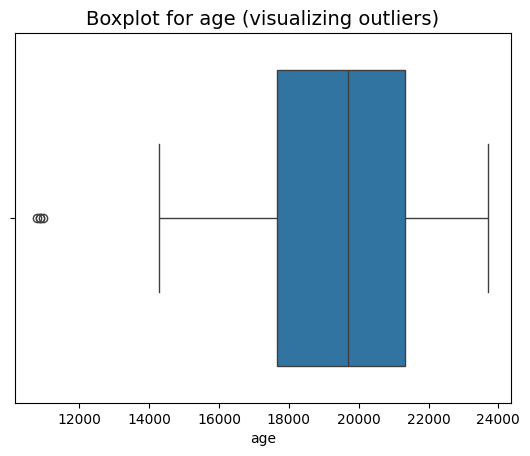

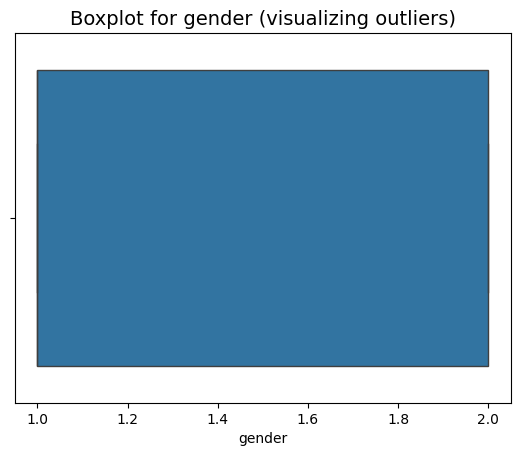

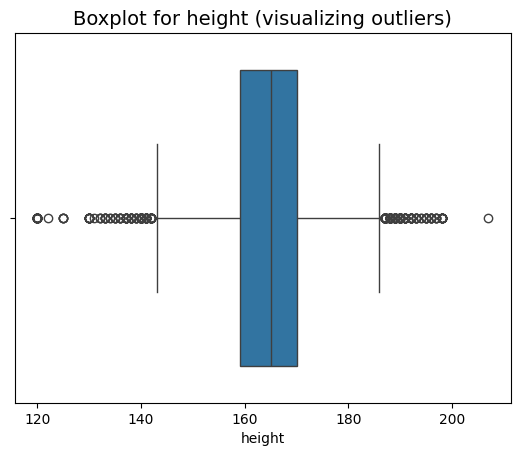

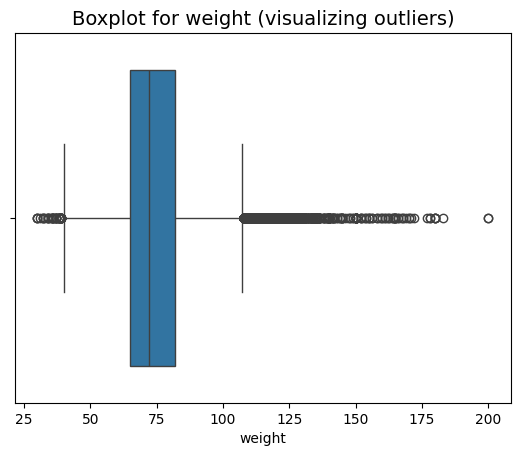

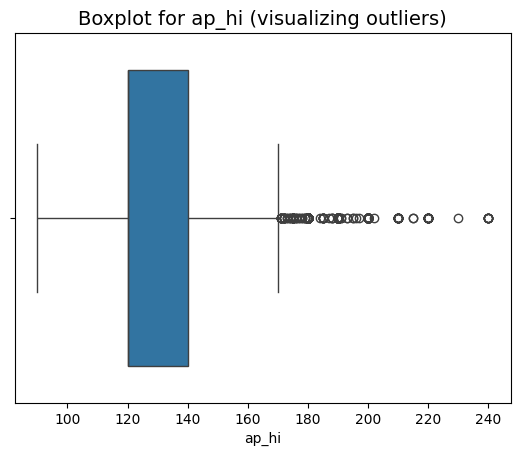

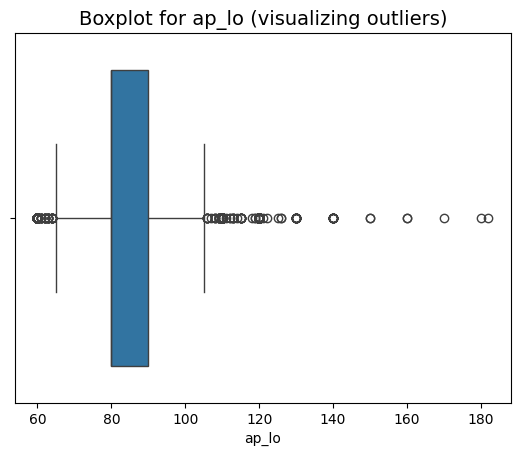

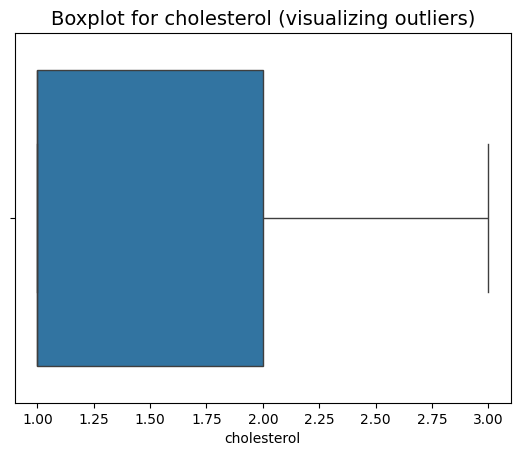

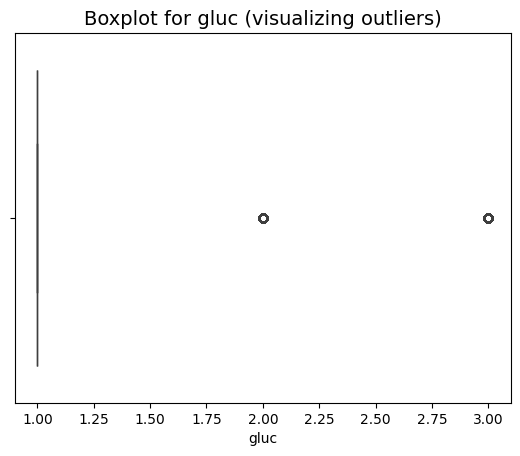

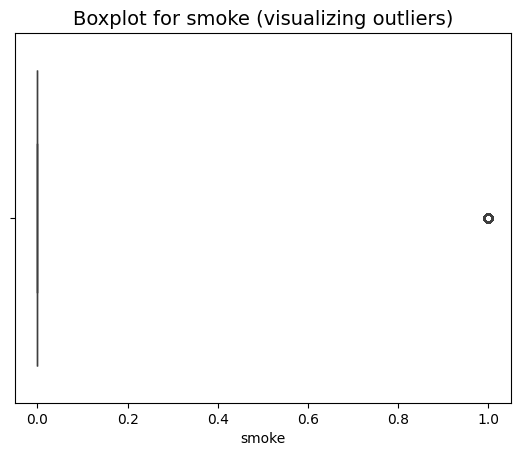

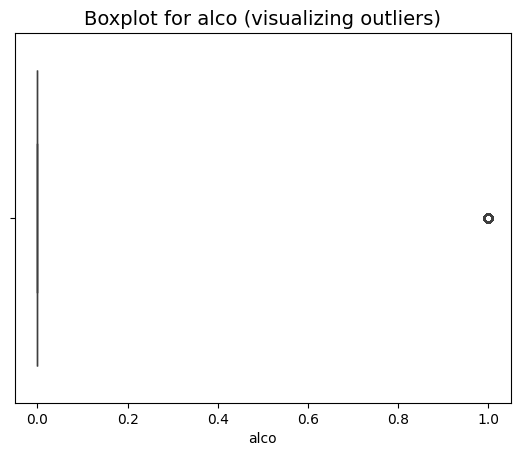

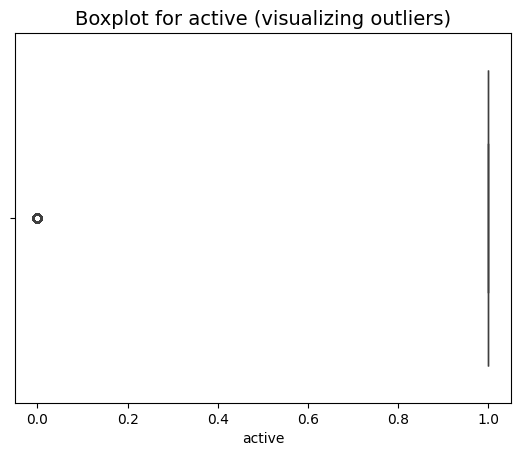

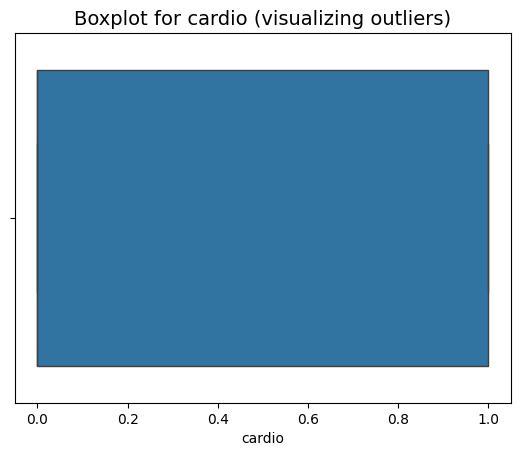

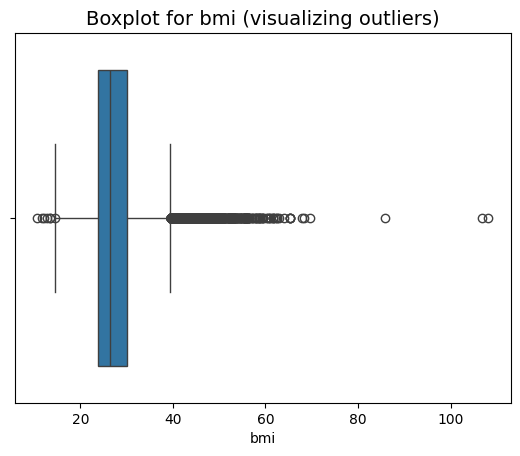

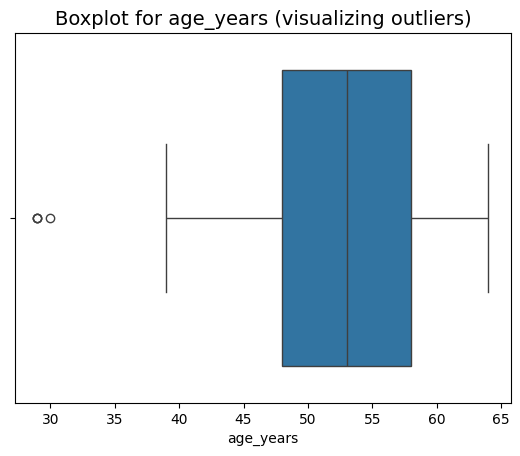

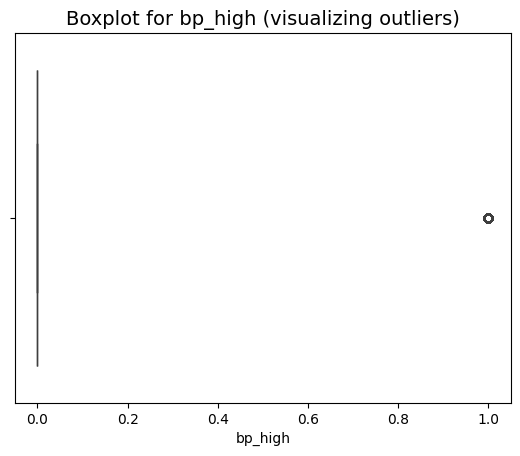

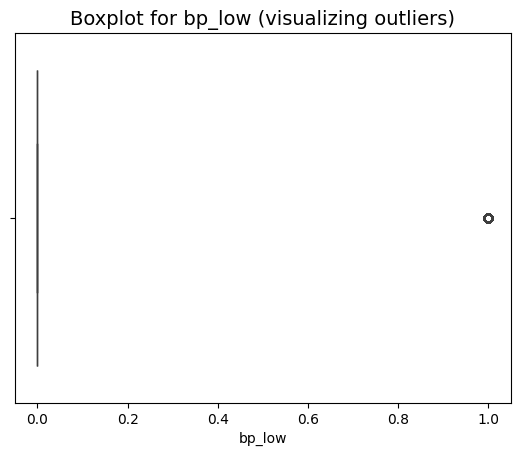

In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt
for col in df.select_dtypes(include="number").columns:
  sns.boxplot(data=df,x=col)
  plt.title(f"Boxplot for {col} (visualizing outliers)",fontsize=14)
  plt.show()

In [13]:
# handling outliears
def handling(col):
  q1,q3 = np.percentile(col,[25,75])
  iqr=q3-q1
  lw = q1 - 1.5*iqr
  up = q3 + 1.5*iqr
  return lw,up
for i in["age","height","weight","ap_hi","ap_lo","bmi","gluc", "active","age_years","bp_high","bp_low"]:
  lw , up = handling(df[i])
  df[i]=np.where(df[i] < lw , lw , df[i])
  df[i]=np.where(df[i] > up,up,df[i])

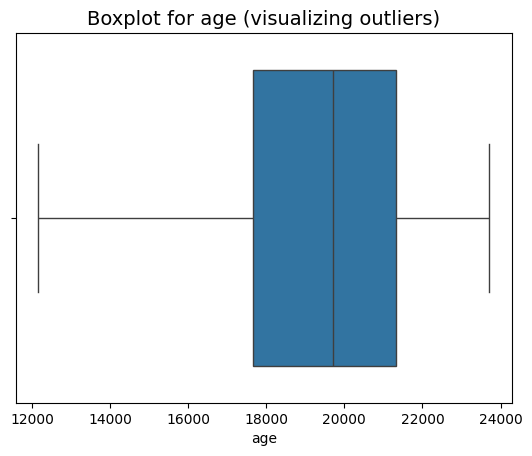

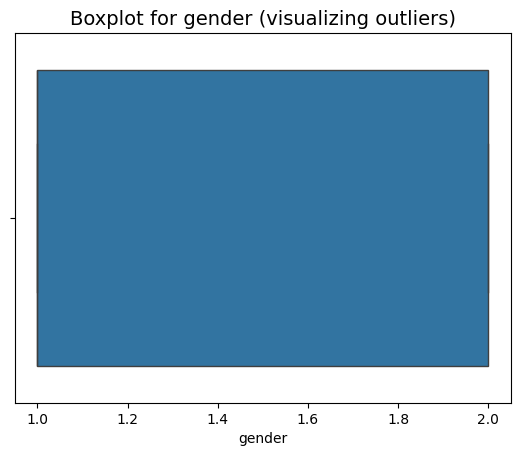

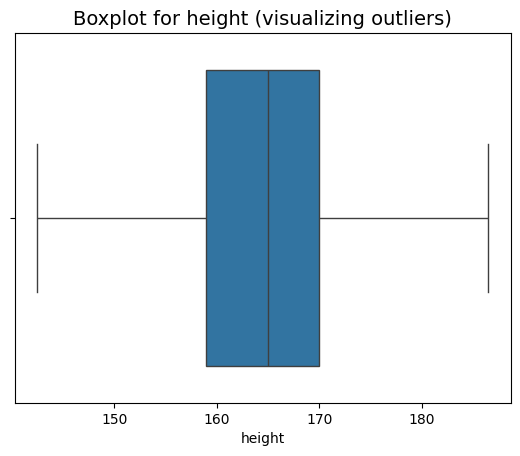

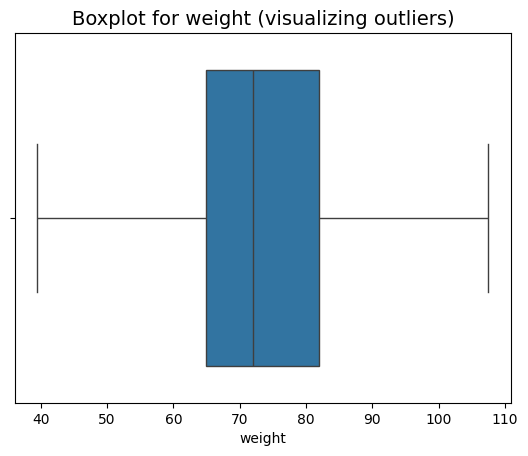

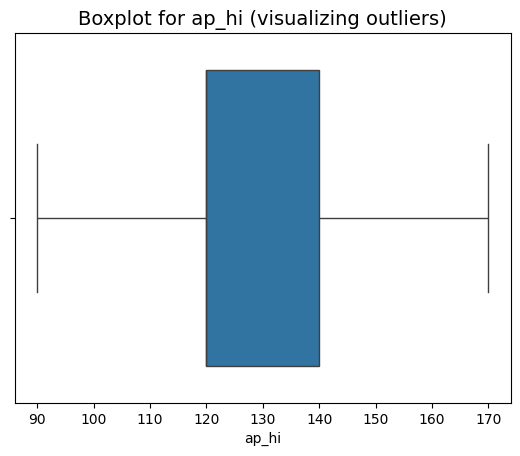

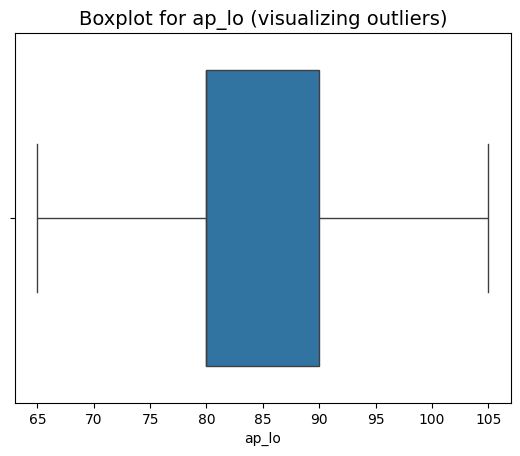

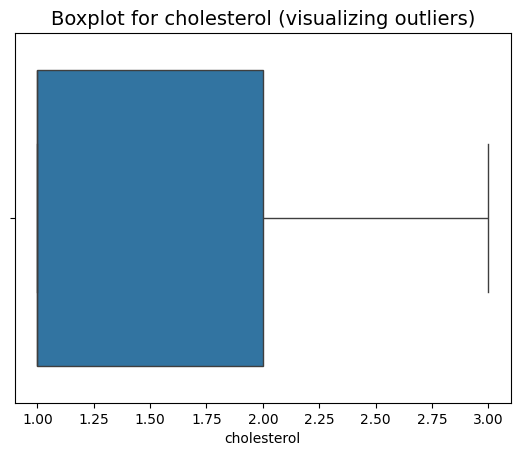

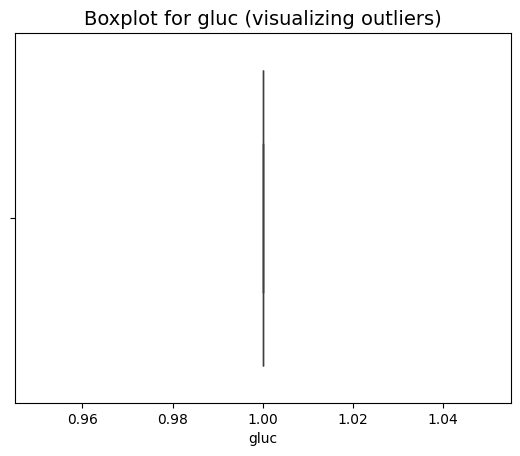

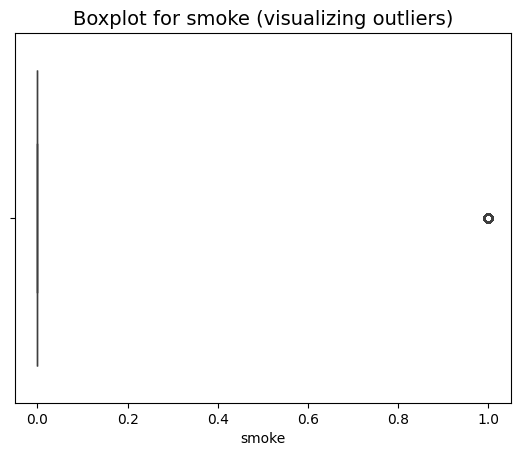

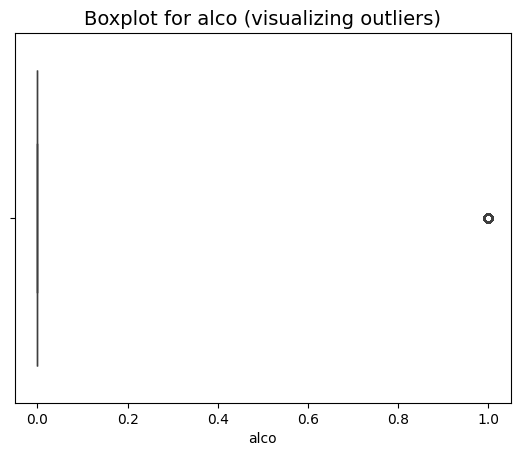

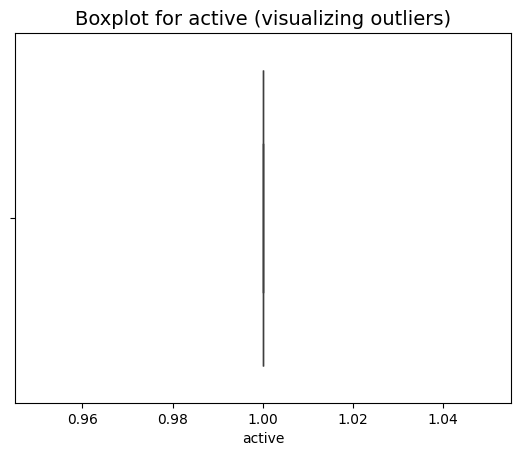

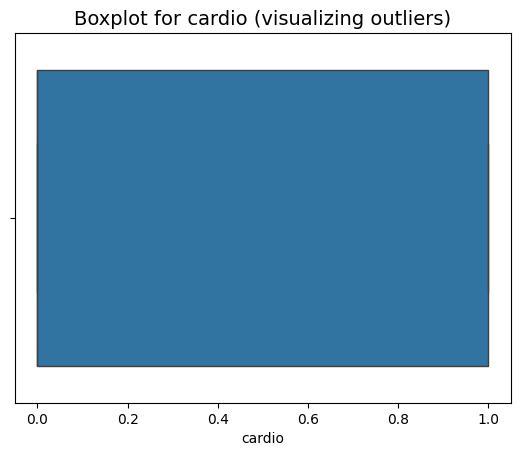

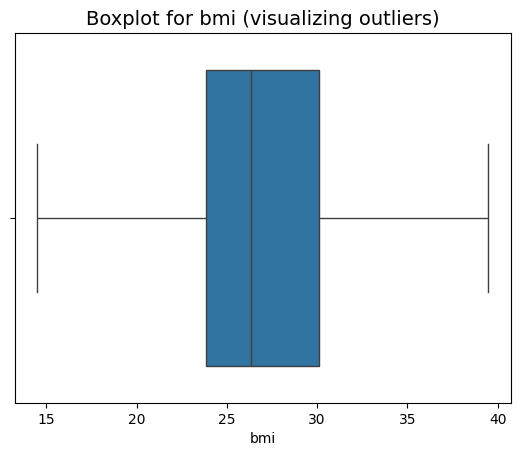

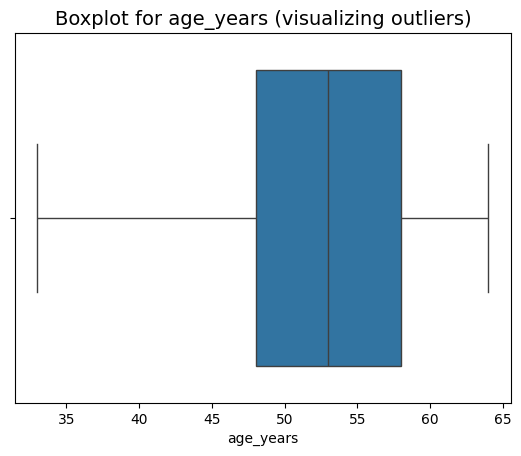

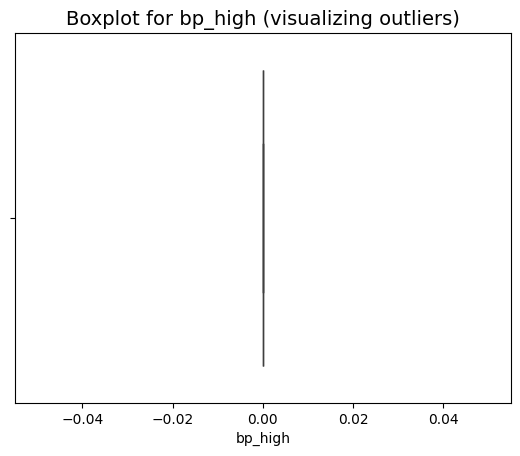

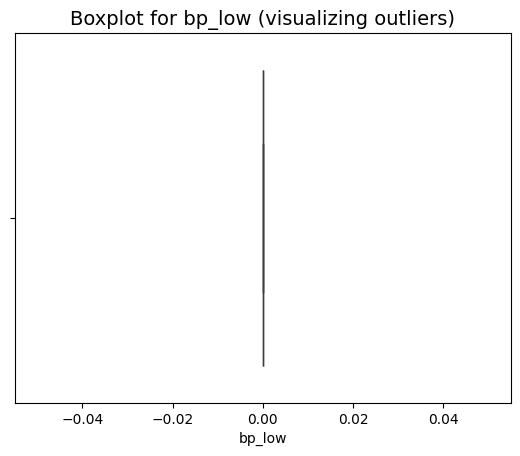

In [14]:
for col in df.select_dtypes(include="number").columns:
  sns.boxplot(data=df,x=col)
  plt.title(f"Boxplot for {col} (visualizing outliers)",fontsize=14)
  plt.show()

Standardization mean = 0 و std = 1

In [ ]:

from sklearn import preprocessing
from sklearn.preprocessing import scale
df["ap_hi"] = preprocessing.scale(df["ap_hi"])
df["ap_lo"] = preprocessing.scale(df["ap_lo"])
df["bmi"] = preprocessing.scale(df["bmi"])
df["weight"] = preprocessing.scale(df["weight"])
df["height"] = preprocessing.scale(df["height"])
df["age"] = preprocessing.scale(df["age"])
df["age_years"] = preprocessing.scale(df["age_years"])
df

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print('Train/Test sizes:', X_train.shape, X_test.shape)
X

Train/Test sizes: (54754, 15) (13689, 15)


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,bmi,age_years,bp_high,bp_low
0,-0.435188,2,0.458131,-0.886765,-1.039714,-0.171730,1,1.0,0,0,1.0,-1.113722,-0.418905,0.0,0.0
1,0.308631,1,-1.082237,0.831273,0.846654,0.988075,3,1.0,0,0,1.0,1.574367,0.320076,0.0,0.0
2,-0.247105,1,0.073039,-0.737371,0.217864,-1.331535,3,1.0,0,0,1.0,-0.794176,-0.271109,0.0,0.0
3,-0.747308,2,0.586495,0.607181,1.475443,2.147881,1,1.0,0,0,1.0,0.284887,-0.714498,0.0,0.0
4,-0.807705,1,-1.082237,-1.334949,-1.668503,-1.911437,1,1.0,0,0,1.0,-0.897179,-0.862294,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,-0.091856,2,0.458131,0.158997,-0.410925,-0.171730,1,1.0,1,0,1.0,-0.084926,-0.123313,0.0,0.0
69996,1.270527,1,-0.825509,2.511962,0.846654,0.988075,2,1.0,0,0,1.0,2.519739,1.206853,0.0,0.0
69997,-0.162387,2,2.383590,2.325219,2.733021,0.988075,3,1.0,0,1,1.0,0.833080,-0.123313,0.0,0.0
69998,1.201618,1,-0.183689,-0.139792,0.532259,-0.171730,1,1.0,0,0,1.0,-0.049291,1.206853,0.0,0.0


Models

In [37]:
from sklearn.model_selection import RandomizedSearchCV
print('Running hyperparameter tuning...')

rf_params = {'n_estimators': [100, 200], 'max_depth': [5, 10, None], 'max_features': ['sqrt', 'log2']}
rf_grid = RandomizedSearchCV( RandomForestClassifier(random_state=42), rf_params,n_iter=8, cv=3, scoring='roc_auc', n_jobs=-1)
rf_grid.fit(X_train, y_train)
rf_best = rf_grid.best_estimator_
print('Best RF:', rf_grid.best_params_)

xgb_params = {'n_estimators': [200], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5, 7]}
xgb_grid = RandomizedSearchCV( XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), xgb_params,n_iter=8, cv=3, scoring='roc_auc', n_jobs=-1)
xgb_grid.fit(X_train, y_train)
xgb_best = xgb_grid.best_estimator_
print('Best XGB:', xgb_grid.best_params_)

lgbm_params = {'n_estimators': [200], 'learning_rate': [0.05, 0.1], 'max_depth': [-1, 5, 10]}
lgbm_grid = RandomizedSearchCV(LGBMClassifier(random_state=42), lgbm_params,n_iter=8, cv=3, scoring='roc_auc', n_jobs=-1)
lgbm_grid.fit(X_train, y_train)
lgbm_best = lgbm_grid.best_estimator_
print('Best LGBM:', lgbm_grid.best_params_)

Running hyperparameter tuning...
Best RF: {'n_estimators': 100, 'max_features': 'log2', 'max_depth': 10}
Best XGB: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.05}
[LightGBM] [Info] Number of positive: 27114, number of negative: 27640
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003797 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 813
[LightGBM] [Info] Number of data points in the train set: 54754, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495197 -> initscore=-0.019214
[LightGBM] [Info] Start training from score -0.019214
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

 evaluate performance metrics

In [ ]:

def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    print(f'=== {name} ===')
    print(classification_report(y_test, y_pred))
    print(f'Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}\n')

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    plt.plot([0,1],[0,1],'--',color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {name}")
    plt.legend()
    plt.show()

=== Random Forest (Tuned) ===
              precision    recall  f1-score   support

           0       0.72      0.77      0.74      6910
           1       0.75      0.69      0.72      6779

    accuracy                           0.73     13689
   macro avg       0.73      0.73      0.73     13689
weighted avg       0.73      0.73      0.73     13689

Accuracy: 0.7324 | Precision: 0.7474 | Recall: 0.6944 | F1: 0.7199 | AUC: 0.7997



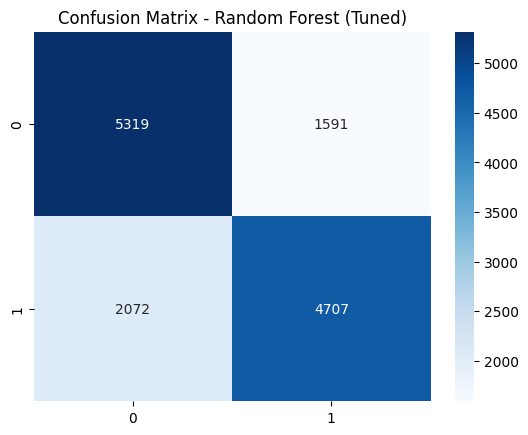

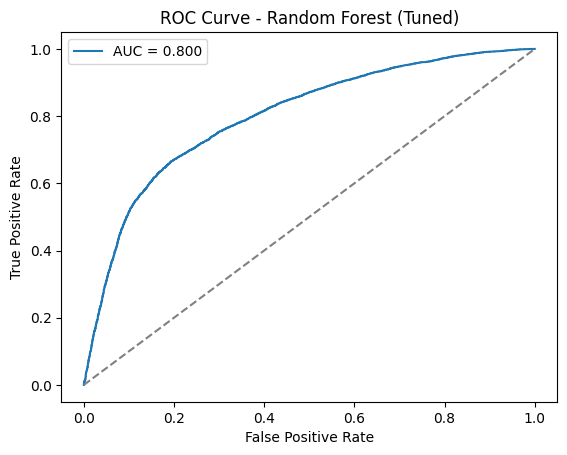

=== XGBoost (Tuned) ===
              precision    recall  f1-score   support

           0       0.72      0.78      0.75      6910
           1       0.75      0.69      0.72      6779

    accuracy                           0.73     13689
   macro avg       0.73      0.73      0.73     13689
weighted avg       0.73      0.73      0.73     13689

Accuracy: 0.7331 | Precision: 0.7511 | Recall: 0.6895 | F1: 0.7190 | AUC: 0.8008



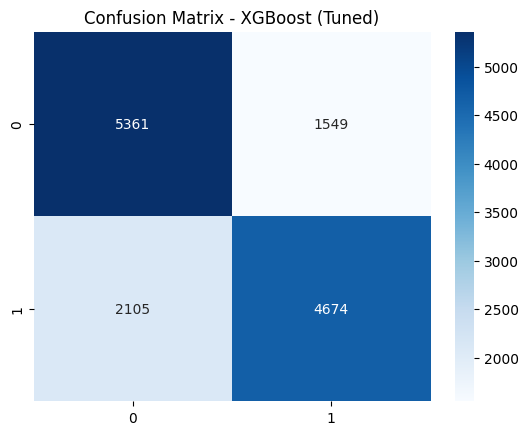

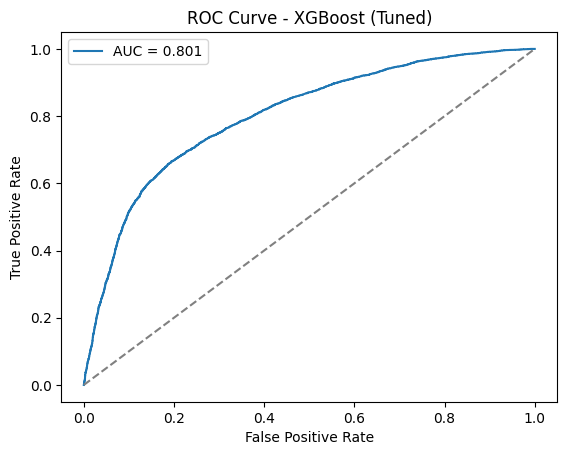

=== LightGBM (Tuned) ===
              precision    recall  f1-score   support

           0       0.72      0.77      0.75      6910
           1       0.75      0.69      0.72      6779

    accuracy                           0.73     13689
   macro avg       0.73      0.73      0.73     13689
weighted avg       0.73      0.73      0.73     13689

Accuracy: 0.7328 | Precision: 0.7503 | Recall: 0.6901 | F1: 0.7189 | AUC: 0.8005



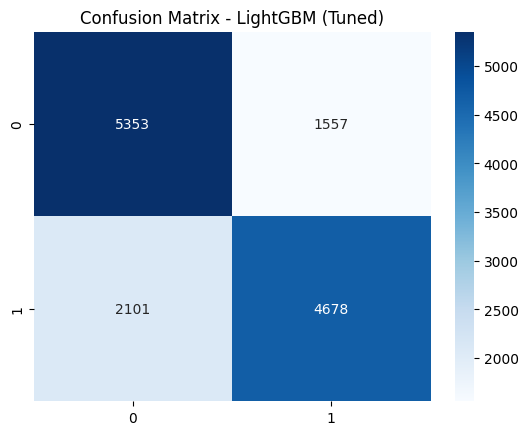

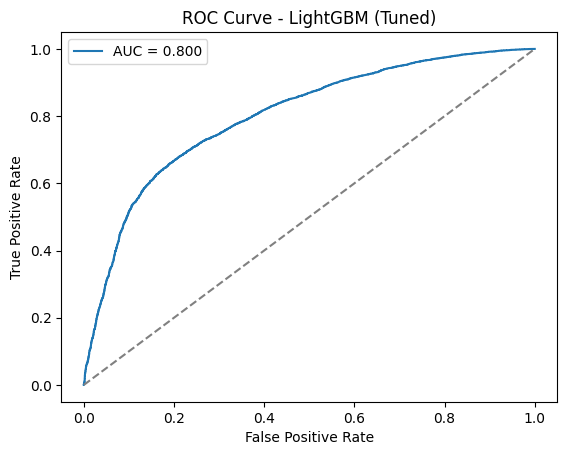

In [39]:
evaluate_model(rf_best, X_test, y_test, 'Random Forest (Tuned)')
evaluate_model(xgb_best, X_test, y_test, 'XGBoost (Tuned)')
evaluate_model(lgbm_best, X_test, y_test, 'LightGBM (Tuned)')


Feature Importance

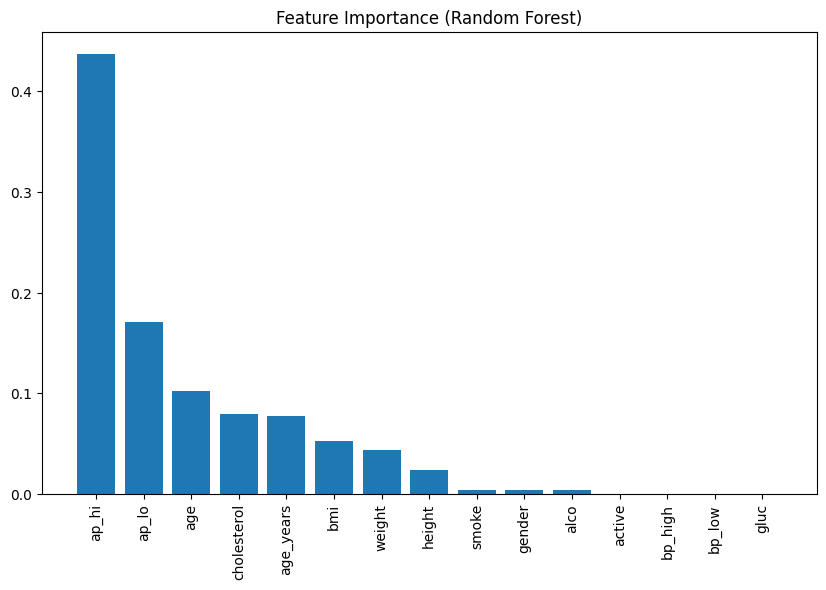

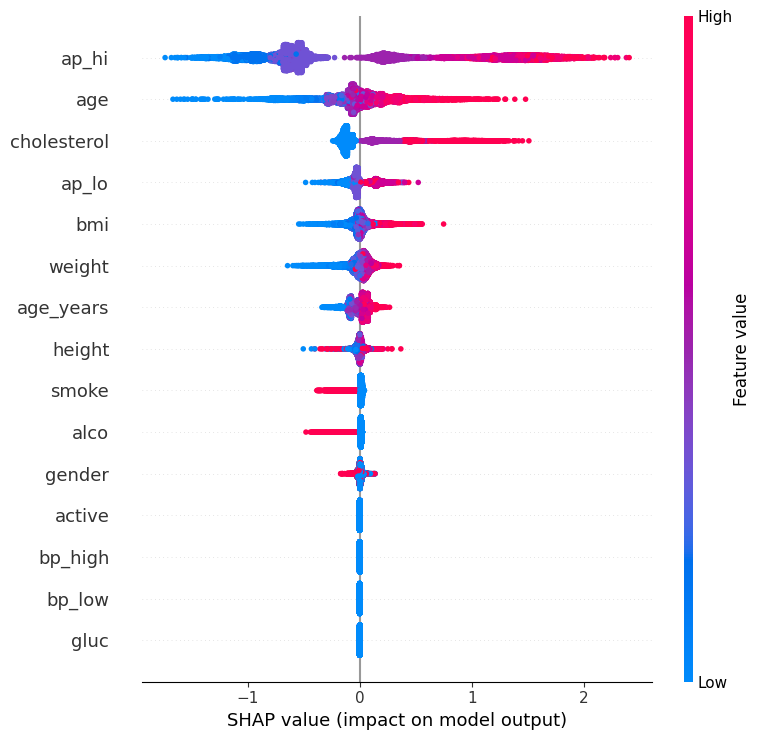

In [40]:
feature_names = X.columns.tolist()

importances = rf_best.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10,6))
plt.title('Feature Importance (Random Forest)')
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), np.array(feature_names)[indices], rotation=90)
plt.show()

explainer = shap.TreeExplainer(xgb_best)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=feature_names)